In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
# Reading and merging all csv files into one dataframe

DATA_DIR = '../data/safety/features'

colnames = ['bookingID', 'Accuracy', 'Bearing', 'acceleration_x',
             'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y',
             'gyro_z', 'second', 'Speed']
raw_df = pd.DataFrame(columns=colnames)

for filename in os.listdir(DATA_DIR):
    if filename !=  '.DS_Store':
        print(os.path.join(os.getcwd(), DATA_DIR, filename))
        new_df = pd.read_csv(os.path.join(os.getcwd(), DATA_DIR, filename))
        raw_df = pd.concat([raw_df, new_df], axis=0, ignore_index=True)
        print(raw_df.shape)

/Users/itn.muhammad.afif/Documents/notebooks/data/safety/features/part-00001-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
(1613558, 11)
/Users/itn.muhammad.afif/Documents/notebooks/data/safety/features/part-00000-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
(3227112, 11)
/Users/itn.muhammad.afif/Documents/notebooks/data/safety/features/part-00003-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
(4840665, 11)
/Users/itn.muhammad.afif/Documents/notebooks/data/safety/features/part-00002-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
(6454220, 11)
/Users/itn.muhammad.afif/Documents/notebooks/data/safety/features/part-00005-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
(8067771, 11)
/Users/itn.muhammad.afif/Documents/notebooks/data/safety/features/part-00009-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
(9681333, 11)
/Users/itn.muhammad.afif/Documents/notebooks/data/safety/features/part-00004-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
(11294892, 11)
/Users/itn.muhammad.afif/Documents/noteb

In [3]:
# Reading in labels csv

LABEL_DIR = os.path.join(os.getcwd(), 'data/safety/labels', 
                         'part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

label_df = pd.read_csv(LABEL_DIR)
label_df.head()

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


In [4]:
# Checking and dropping the 18 duplicate bookingIDs 

label_counts = np.unique(label_df['bookingID'].values, return_counts=True)
label_counts = pd.DataFrame({'bookingID' : label_counts[0], 
                             'counts' : label_counts[1]})

dup = label_counts[label_counts['counts'] > 1]

dup_id = dup['bookingID'].values

# bookingIDs are labelled both 0 and 1, drop these IDs since we have sufficient data

for b in dup_id:
    idx1 = label_df[label_df['bookingID'] == b].index
    idx2 = raw_df[raw_df['bookingID'] == b].index

    label_df = label_df.drop(idx1, axis=0)
    raw_df = raw_df.drop(idx2, axis=0)
    
df = pd.merge(raw_df, label_df)

In [5]:
# Dropping inaccurate readings 
# i.e. rows with accuracy > 30 and speed < 0

df = df.loc[(df['Accuracy'] <= 30) & (df['Speed'] >= 0)]

### Feature Engineering

Adding additional columns 
1. Distance = 'Speed' * 'second' 
2. Acceleration = sqrt('acceleration_x' ** 2, 'acceleration_y' ** 2, 'acceleration_z' ** 2) 
3. gyro_pc (magnitude) = PC1 of PCA applied on gyro_x, gyro_y, gyro_z
4. Speed_diff = per second difference in speed for each bookingID
5. Bearing_diff = per second difference in bearing for each bookingID

In [6]:
df_add = df.copy(deep=True).sort_values(by=['bookingID', 'second']).reset_index(drop=True)

# Applying PCA to gyro coordinates

from sklearn.decomposition import PCA

gyro_cols = ['gyro_x', 'gyro_y', 'gyro_z']
gyro_coord = df_add[gyro_cols]
pca = PCA()

pca.fit(gyro_coord)
pca.explained_variance_ratio_

array([0.75386447, 0.12894376, 0.11719177])

In [7]:
# Since first PC accounts for > 70% of variance, we only keep 1 PC to explain gyro

df_add['gyro_pc'] = pca.transform(df_add[gyro_cols])[:, 0]
df_add.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,gyro_pc
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0,-0.089042
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0,-0.076595
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0,-0.032230
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0,0.002411
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0,-0.044964


In [8]:
# Adding distance, acceleration and magnitude columns

df_add['distance'] = df_add['Speed'] * df_add['second']
df_add['acceleration'] = np.sqrt(np.power(df_add['acceleration_x'], 2) + 
                                 np.power(df_add['acceleration_y'], 2) + 
                                 np.power(df_add['acceleration_z'], 2))

In [9]:
# Function to calculate difference in speed per second
def calc_speed_diff(x):
    return x['Speed'].diff()

# Function to calculate difference in bearing per second
def calc_bearing_diff(x):
    return x['Bearing'].diff()

# sub_df is a dataframe containing differences in speed and bearing
# values per second
# Large change in speed == sudden speeding/braking
# Large change in bearing == sudden change in direction/lane change

df_add['speed_diff'] = df_add.groupby('bookingID').apply(calc_speed_diff).fillna(method="backfill").values
df_add['bearing_diff'] = df_add.groupby('bookingID').apply(calc_bearing_diff).fillna(method="backfill").values

In [10]:
df_add.head(n=10)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,gyro_pc,distance,acceleration,speed_diff,bearing_diff
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0,-0.089042,0.000000,10.176551,-3.214536,0.0
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0,-0.076595,0.228454,10.059553,-3.214536,0.0
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0,-0.032230,0.456909,9.503762,0.000000,0.0
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0,0.002411,0.685363,9.830320,0.000000,0.0
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0,-0.044964,0.913818,9.967466,0.000000,0.0
5,0,8.0,143.298294,-0.608313,-9.539658,-1.794583,-0.007538,-0.023838,0.018068,5.0,0.228454,0,-0.022816,1.142272,9.726029,0.000000,0.0
6,0,8.0,143.298294,-0.867758,-9.698615,-1.615439,0.022728,-0.012178,0.005982,6.0,0.228454,0,-0.011493,1.370727,9.870449,0.000000,0.0
7,0,8.0,143.298294,-1.050790,-9.745270,-1.411771,0.027603,0.001841,0.000904,7.0,0.228454,0,0.002201,1.599181,9.902906,0.000000,0.0
8,0,8.0,143.298294,-0.721213,-9.960004,-1.202271,0.001864,-0.007702,0.014018,8.0,0.228454,0,-0.006844,1.827636,10.058194,0.000000,0.0
9,0,8.0,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454,0,-0.047958,2.056090,9.614707,0.000000,0.0


### Creating df_sub1: aggregation of variables 
Taking mean, median, standard deviation, spread of acceleration, gyro_pc, speed and second

In [ ]:
def spread(x):
    return x.max() - x.min()

df_sub1 = df_add.groupby('bookingID')['acceleration', 'gyro_pc', 'Speed', 'second'].aggregate([
    'mean', 'median', 'std', spread
])

df_sub1.columns = ["_".join(x) for x in df_sub1.columns.ravel()]
df_sub1.columns = [col.lower() for col in df_sub1.columns]
df_sub1 = df_sub1.fillna(0)

In [ ]:
df_sub1.head(n=10)

### Creating df_sub2: detecting outlier values for speed, second, acceleration, gyro

In [ ]:
print(df_add.columns)

# Checking 75th percentile for speed and second
# Checking 25th and 75th percentile for acceleration, gyro coordinates

outlier_vals = {'Speed_75' : np.quantile(df_add['Speed'], 0.75),
               'second_75' : np.quantile(df_add['second'], 0.75),
               'acceleration_x_25' : np.quantile(df_add['acceleration_x'], 0.25), 
               'acceleration_y_25' : np.quantile(df_add['acceleration_y'], 0.25),
               'acceleration_z_25' : np.quantile(df_add['acceleration_z'], 0.25),
               'acceleration_x_75' : np.quantile(df_add['acceleration_x'], 0.75),
               'acceleration_y_75' : np.quantile(df_add['acceleration_y'], 0.75),
               'acceleration_z_75' : np.quantile(df_add['acceleration_z'], 0.75),
               'gyro_x_25' : np.quantile(df_add['gyro_x'], 0.25),
               'gyro_y_25' : np.quantile(df_add['gyro_y'], 0.25),
               'gyro_z_25' : np.quantile(df_add['gyro_z'], 0.25),
               'gyro_x_75' : np.quantile(df_add['gyro_x'], 0.75),
               'gyro_y_75' : np.quantile(df_add['gyro_y'], 0.75),
               'gyro_z_75' : np.quantile(df_add['gyro_z'], 0.75)}

outlier_vals

In [ ]:
def quantile_check(x, col, q):
    val = outlier_vals['{}_{}'.format(col, q)]
    
    if q == 25:
        return np.sum(x[col] < val)
    elif q == 75:
        return np.sum(x[col] > val)
    

df_sub2 = pd.DataFrame()
    
colnames = ['acceleration_x', 'acceleration_y', 'acceleration_z', 
           'gyro_x', 'gyro_y', 'gyro_z']

df_sub2['over_Speed'] = df_add.groupby('bookingID').apply(quantile_check, col='Speed', q=75)
df_sub2['over_second'] = df_add.groupby('bookingID').apply(quantile_check, col='second', q=75)

for col in colnames:
    print(col)
    arr = df_add.groupby('bookingID').apply(quantile_check, col=col, 
                                             q=25).values + df_add.groupby('bookingID').apply(quantile_check, 
                                                                                              col=col, q=75).values
    df_sub2['over_{}'.format(col)] = arr

In [ ]:
df_add2 = pd.merge(df_sub1, df_sub2, on='bookingID')
df_add2 = pd.merge(df_add2, label_df, on='bookingID')
df_add2.columns = [col.lower() for col in df_add2.columns]

### Creating df_sub3: sliding window + kmeans

In [126]:
window_features = df_add[['bookingID', 'Speed', 'acceleration', 'gyro_pc']].groupby('bookingID')
# ids = np.random.choice(window_features['bookingID'].unique(), size=20)
# window_features2 = window_features[window_features['bookingID'].isin(ids)].groupby('bookingID')

In [127]:
def sliding_window(df, step=8, overlap=4):
    df = df.reset_index(drop=True)
    start_idx = df.index.values[0]
    end_idx = df.index.values[-1]
        
    booking_df = pd.DataFrame(columns=['Speed_mean', 'acceleration_mean', 'gyro_pc_mean', 
                                       'Speed_median', 'acceleration_median', 'gyro_pc_median', 
                                       'Speed_std', 'acceleration_std', 'gyro_pc_std'])    
    
    while start_idx <= (end_idx - step):
        agg_vals = df.iloc[start_idx: start_idx + step, ].aggregate(['mean', 'median', 'std'])
        agg_vals = agg_vals.unstack().to_frame().sort_index(level=1).T
        agg_vals.columns = agg_vals.columns.map('_'.join)
        
        booking_df = pd.concat([booking_df, agg_vals], axis=0)
        
        start_idx += overlap

    return booking_df
    

    
import datetime
start_time = datetime.datetime.now()
print("Start time: {}".format(start_time))

window_features3 = window_features.rolling(8).agg(['mean', 'median', 'std']).dropna()[::4]

end_time = datetime.datetime.now()
print("End time: {}".format(end_time))

print("Total time taken: {} seconds".format((end_time - start_time).seconds))

Start time: 2020-01-22 16:50:30.958301
End time: 2020-01-22 16:54:43.687220
Total time taken: 252 seconds


In [131]:
window_features4 = window_features3.drop('bookingID', axis=1)
window_features4.columns = ['_'.join(col) for col in window_features4.columns]

In [132]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
window_features5 = pd.DataFrame(scaler.fit_transform(window_features4), columns=window_features4.columns)
window_features5.describe()

,Speed_mean,Speed_median,Speed_std,acceleration_mean,acceleration_median,acceleration_std,gyro_pc_mean,gyro_pc_median,gyro_pc_std
count,3.877881e+06,3.877881e+06,3.877881e+06,3.877881e+06,3.877881e+06,3.877881e+06,3.877881e+06,3.877881e+06,3.877881e+06
mean,-1.365092e-14,-7.275459e-16,6.578162e-15,-2.779192e-15,3.467821e-16,-4.998799e-16,-6.379474e-16,-4.466214e-16,4.909099e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.152617e+00,-1.143184e+00,-9.523907e-01,-9.642417e+00,-9.728831e+00,-1.006587e+00,-7.941451e+01,-7.958804e+01,-4.085239e-01
25%,-9.522836e-01,-9.724224e-01,-7.265436e-01,-1.921331e-01,-1.870297e-01,-6.000002e-01,-6.518912e-02,-6.063059e-02,-3.200413e-01
50%,-1.798228e-01,-1.679168e-01,-3.079850e-01,-5.540043e-02,-4.741574e-02,-1.643632e-01,-6.647250e-06,-1.270189e-03,-1.642449e-01
75%,7.957034e-01,7.997348e-01,4.264326e-01,1.111327e-01,1.164941e-01,3.373348e-01,7.019385e-02,6.355228e-02,7.566038e-02
max,3.927706e+00,3.914888e+00,2.654098e+01,4.318909e+01,4.594969e+01,6.287460e+01,5.462168e+01,4.909628e+01,1.357444e+02


In [109]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    print(k)
    
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(window_features4)     
      
    distortions.append(sum(np.min(cdist(window_features4, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / window_features4.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(window_features4, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / window_features4.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

1
2
3
4
5
6
7
8
9


In [110]:
for key,val in mapping1.items(): 
	print(str(key)+' : '+str(val)) 


1 : 2.0061110079726756
2 : 1.5331354192256332
3 : 1.494044346760681
4 : 1.4852326035757575
5 : 1.2627790764455793
6 : 1.2497364645186906
7 : 1.2244582530384456
8 : 1.2115581605287848
9 : 1.1149194318037847


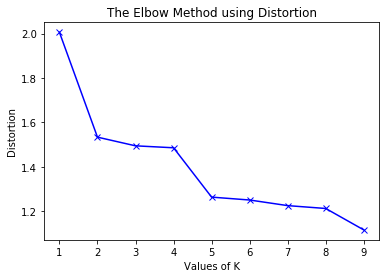

In [111]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() # Should keep 5 clusters

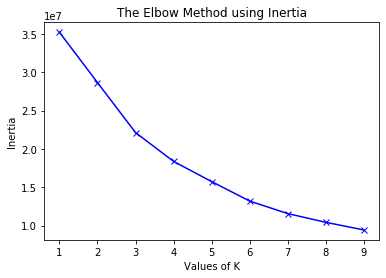

In [113]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [133]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(window_features5)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [134]:
window_features5['cluster'] = kmeans.predict(window_features5)
window_features5['cluster'] += 1
window_features5['cluster'].value_counts()

1    1461393
5    1432435
2     979924
3       3826
4        303
Name: cluster, dtype: int64

In [153]:
booking_ids = []

for idx in window_features3.index:
    booking_ids.append(idx[0])
    
len(booking_ids)

3877881

In [154]:
window_features5['bookingID'] = booking_ids

### Older (unused) pre-processing/aggregation

In [ ]:
# df_add2 = df_add.groupby('bookingID').aggregate({'second' : ['min', 'mean', 'max', 'median', 'std', spread], 
#                                                  'Speed' : ['min', 'mean', 'max', 'median', 'std', spread], 
#                                                 'distance' : ['min', 'mean', 'max', 'median', 'std', spread],
#                                                 'acceleration' : ['min', 'mean', 'max', 'median', 'std', spread],
#                                                 'gyro_pc' : ['min', 'mean', 'max', 'median', 'std', spread],
#                                                 'speed_diff' : ['min', 'mean', 'max', 'median', 'std', spread],
#                                                 'bearing_diff' : ['min', 'mean', 'max', 'median', 'std', spread]})

# df_add2.columns = ["_".join(x) for x in df_add2.columns.ravel()]
# df_add2 = pd.merge(df_add2, label_df, on='bookingID').drop('bookingID', axis='columns')
# df_add2.columns = [col.lower() for col in df_add2.columns]

In [ ]:
df_add2.head(n=10)

In [ ]:
# Checking for correlations within aggregated data
# Particularly, check for correlations between different features 
# e.g. strong correlation between accuracy and speed etc

corr_matrix = df_add2.corr()
corr_matrix.where((corr_matrix > 0.5) & (corr_matrix != 1))

In [ ]:
# def plot_corr_heatmap(df, vmax=1.0):
#     corr_matrix = df.corr()
    
#     mask = np.zeros_like(corr_matrix, dtype=np.bool)
#     mask[np.triu_indices_from(mask)] = True

#     # Set up the matplotlib figure
#     f, ax = plt.subplots(figsize=(11, 9))

#     # Generate a custom diverging colormap
#     cmap = sns.diverging_palette(220, 10, as_cmap=True)

#     # Draw the heatmap with the mask and correct aspect ratio
#     sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=vmax, 
#                 square=True, center=0, linewidths=.5)
    
# plot_corr_heatmap(df, vmax=0.6)

In [ ]:
# sns.pairplot(df_add2, hue='label')

### Generating CSV for use in modelling.ipynb

In [ ]:
SAVE_DIR = os.path.join(os.getcwd(), 'data/safety/')

df_add2.to_csv(SAVE_DIR + "kfengtee.csv", index=False)